# ANOVOS - Data Drift and Stability Index
Following notebook shows the list of "data drift and stability" related functions supported under ANOVOS package and how it can be invoked accordingly
- [Data Drift Statistics](#Data-Drift-Statistics)
- [Attribute Stability Index](#Data-Stability-Index)
- [Feature Stability Estimation](#Feature-Stability-Estimation)
- [Appendix: Attribute Stability Index Result Visualization](#Appendix:-Attribute-Stability-Index-Result-Visualization)

**Setting up Spark Session**

In [3]:
#set run type variable
run_type = "local" # "local", "emr", "databricks", "ak8s"

In [4]:
#For run_type Azure Kubernetes, run the following block 
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

if run_type == "ak8s":
    fs_path="<insert conf spark.hadoop.fs master url here> ex: spark.hadoop.fs.azure.sas.<container>.<account_name>.blob.core.windows.net"
    auth_key="<insert value of sas_token here>"
    master_url="<insert kubernetes master url path here> ex: k8s://"
    docker_image="<insert name docker image here>"
    kubernetes_namespace ="<insert kubernetes namespace here>"

    # Create Spark config for our Kubernetes based cluster manager
    sparkConf = SparkConf()
    sparkConf.setMaster(master_url)
    sparkConf.setAppName("Anovos_pipeline")
    sparkConf.set("spark.submit.deployMode","client")
    sparkConf.set("spark.kubernetes.container.image", docker_image)
    sparkConf.set("spark.kubernetes.namespace", kubernetes_namespace)
    sparkConf.set("spark.executor.instances", "4")
    sparkConf.set("spark.executor.cores", "4")
    sparkConf.set("spark.executor.memory", "16g")
    sparkConf.set("spark.kubernetes.pyspark.pythonVersion", "3")
    sparkConf.set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
    sparkConf.set(fs_path,auth_key)
    sparkConf.set("spark.kubernetes.authenticate.serviceAccountName", "spark")
    sparkConf.set("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.2.0,com.microsoft.azure:azure-storage:8.6.3,io.github.histogrammar:histogrammar_2.12:1.0.20,io.github.histogrammar:histogrammar-sparksql_2.12:1.0.20,org.apache.spark:spark-avro_2.12:3.2.1")

    # Initialize our Spark cluster, this will actually
    # generate the worker nodes.
    spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
    sc = spark.sparkContext

#For other run types import from anovos.shared.
else:
    from anovos.shared.spark import *
    auth_key = "NA"

In [3]:
sc.setLogLevel("ERROR")
import warnings
warnings.filterwarnings('ignore')

**Input/Output Path** 

In [4]:
driftTargetPath = '../data/income_dataset/csv'
driftSourcePath = '../data/income_dataset/source'
stabilityPath = '../data/income_dataset/stability_index/'
outputPath = "../output/income_dataset/data_drift/"

## Data Drift Statistics
- API specification of function **statistics** can be found <a href="https://docs.anovos.ai/api/drift/detector.html">here</a>
- Supports 5 different ways of computing the drift statistics between target and source datasets.

In [5]:
from anovos.drift.detector import statistics

In [6]:
# Read source and target datasets
from anovos.data_ingest.data_ingest import read_dataset
target_df = read_dataset(spark, driftTargetPath,"csv", {'header':True,'inferSchema':True}).drop("dt_1", "dt_2")
source_df = read_dataset(spark, driftSourcePath,"csv", {'header':True,'inferSchema':True}).drop("dt_1", "dt_2")

In [7]:
# Example 1 - all columns + drift metric PSI
result_PSI = statistics(spark, target_df, source_df)
result_PSI.toPandas()

2022-06-06 20:38:47.824 | DEBUG    | anovos.drift.validations:validate:20 - check the list of columns


attribute     PSI  flagged
0   hours-per-week  0.0000        0
1        workclass  0.0002        0
2              ifa  0.0000        0
3     relationship  0.0000        0
4           logfnl  0.0000        0
5        education  0.0000        0
6   marital-status  0.0000        0
7    education-num  0.0000        0
8   native-country  0.0000        0
9       occupation  0.0000        0
10           empty  0.0000        0
11            race  0.0000        0
12             sex  0.0000        0
13          fnlwgt  0.0000        0
14    capital-gain  0.0000        0
15    capital-loss  0.0000        0
16             age  0.0000        0
17          income  0.0000        0

In [8]:
# Example 2 - selected columns + drift metric PSI
result_PSI = statistics(spark, target_df, source_df, 
                        list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'],
                        threshold=0.1)
result_PSI.toPandas()

2022-06-06 20:39:16.946 | DEBUG    | anovos.drift.validations:validate:20 - check the list of columns


attribute  PSI  flagged
0  hours-per-week  0.0        0
1    capital-gain  0.0        0
2             age  0.0        0
3   education-num  0.0        0

In [9]:
# Example 3 - selected columns + compute statistics of JSD, HD and KS with a different bin_size
result_others = statistics(spark, target_df, source_df, 
                           list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                           method_type=['JSD','HD','KS'], bin_size=100)
result_others.toPandas()

2022-06-06 20:39:22.800 | DEBUG    | anovos.drift.validations:validate:20 - check the list of columns


attribute  JSD   HD   KS  flagged
0  hours-per-week  0.0  0.0  0.0        0
1    capital-gain  0.0  0.0  0.0        0
2             age  0.0  0.0  0.0        0
3   education-num  0.0  0.0  0.0        0

In [10]:
# Example 4 - selected columns + save model
result_others = statistics(spark, target_df, source_df, 
                           list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                           pre_existing_source=False, source_path=outputPath)
result_others.toPandas()

2022-06-06 20:39:29.367 | DEBUG    | anovos.drift.validations:validate:20 - check the list of columns


attribute  PSI  flagged
0  hours-per-week  0.0        0
1    capital-gain  0.0        0
2             age  0.0        0
3   education-num  0.0        0

In [11]:
# Example 5 - selected columns + use pre-saved model
result_others = statistics(spark, target_df, source_df, 
                           list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                           pre_existing_source=True, source_path=outputPath)
result_others.toPandas()

2022-06-06 20:39:33.712 | DEBUG    | anovos.drift.validations:validate:20 - check the list of columns


attribute  PSI  flagged
0  hours-per-week  0.0        0
1    capital-gain  0.0        0
2             age  0.0        0
3   education-num  0.0        0

## Data Stability Index 
- API specification of function **stability_index_computation** can be found <a href="https://docs.anovos.ai/api/drift/detector.html">here</a>

In [12]:
from anovos.drift.detector import stability_index_computation

In [13]:
# Read input datasets
df1 = read_dataset(spark, stabilityPath+"0","csv",{'header':True,'inferSchema':True})
df2 = read_dataset(spark, stabilityPath+"1","csv",{'header':True,'inferSchema':True})
df3 = read_dataset(spark, stabilityPath+"2","csv",{'header':True,'inferSchema':True})
df4 = read_dataset(spark, stabilityPath+"3","csv",{'header':True,'inferSchema':True})
df5 = read_dataset(spark, stabilityPath+"4","csv",{'header':True,'inferSchema':True})
df6 = read_dataset(spark, stabilityPath+"5","csv",{'header':True,'inferSchema':True})
df7 = read_dataset(spark, stabilityPath+"6","csv",{'header':True,'inferSchema':True})
df8 = read_dataset(spark, stabilityPath+"7","csv",{'header':True,'inferSchema':True})
df9 = read_dataset(spark, stabilityPath+"8","csv",{'header':True,'inferSchema':True})
df10 = read_dataset(spark, stabilityPath+"9","csv",{'header':True,'inferSchema':True})
df11 = read_dataset(spark, stabilityPath+"10","csv",{'header':True,'inferSchema':True})
df12 = read_dataset(spark, stabilityPath+"11","csv",{'header':True,'inferSchema':True})

In [14]:
df1.toPandas().head(5)

ifa  age  fnlwgt    logfnl  education_num  capital_gain  capital_loss  \
0  27a   19  168294  5.226069              9             0             0   
1  32a   20  266015  5.424906             10             0             0   
2  38a   19  544091  5.735672              9             0             0   
3  52a   18  226956  5.355942              9             0             0   
4  71a   19  101509  5.006505             10             0             0   

   hours_per_week  income_label  gender_label  
0              40             0             0  
1              44             0             0  
2              25             0             1  
3              30             0             1  
4              32             0             0

In [15]:
# Example 1 - input only one dataset
df_stability = stability_index_computation(spark, df1, appended_metric_path=outputPath+'historical_metric_1')
df_stability.toPandas() # result: should be all NaN because there is only one dataset

attribute  mean_cv  stddev_cv  kurtosis_cv  mean_si  stddev_si  \
0    income_label      NaN        NaN          NaN      NaN        NaN   
1          logfnl      NaN        NaN          NaN      NaN        NaN   
2    gender_label      NaN        NaN          NaN      NaN        NaN   
3    capital_gain      NaN        NaN          NaN      NaN        NaN   
4          fnlwgt      NaN        NaN          NaN      NaN        NaN   
5    capital_loss      NaN        NaN          NaN      NaN        NaN   
6  hours_per_week      NaN        NaN          NaN      NaN        NaN   
7             age      NaN        NaN          NaN      NaN        NaN   
8   education_num      NaN        NaN          NaN      NaN        NaN   

   kurtosis_si  stability_index  flagged  
0          NaN              NaN        1  
1          NaN              NaN        1  
2          NaN              NaN        1  
3          NaN              NaN        1  
4          NaN              NaN        1  
5          NaN              NaN        1  
6          NaN              NaN        1  
7          NaN              NaN        1  
8          NaN              NaN        1

In [16]:
# Read saved intermediate statistics in Example 1
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1","csv",{'header':True,'inferSchema':True})
df_intermediate.toPandas()

idx       attribute           mean         stddev    kurtosis
0    1    income_label       0.001096       0.033113  910.001098
1    1          logfnl       5.217221       0.291681    3.554139
2    1    gender_label       0.476974       0.499744    1.008501
3    1    capital_gain     143.787281    1965.965077  293.243575
4    1          fnlwgt  199011.575658  112956.123267    5.508391
5    1    capital_loss      40.483553     265.644311   44.091347
6    1  hours_per_week      29.103070      12.360231    3.088445
7    1             age      18.835526       1.053627    1.924572
8    1   education_num       8.663377       1.620281    3.873733

In [17]:
# Example 2 - input a few more datasets and append to existing result + nondefault threshold
df_stability = stability_index_computation(spark, df2,df3,df4,df5, 
                                           existing_metric_path=outputPath+'historical_metric_1', 
                                           appended_metric_path=outputPath+'historical_metric_1to5',threshold=2)
df_stability.toPandas()

attribute  mean_cv  stddev_cv  kurtosis_cv  mean_si  stddev_si  \
0    income_label   0.8876     0.5794       1.8351        0          0   
1          logfnl   0.0016     0.0320       0.0516        4          3   
2    gender_label   0.1682     0.0317       0.2063        2          3   
3    capital_gain   0.5833     0.4098       0.3902        0          1   
4          fnlwgt   0.0175     0.0212       0.2742        4          4   
5    capital_loss   0.3178     0.1611       0.3552        1          2   
6  hours_per_week   0.1326     0.0877       0.2615        2          3   
7             age   0.1806     0.1304       0.1169        2          2   
8   education_num   0.0606     0.1482       0.0981        3          2   

   kurtosis_si  stability_index  flagged  
0            0              0.0        1  
1            3              3.5        0  
2            1              2.1        0  
3            1              0.5        1  
4            1              3.4        0  
5            1              1.3        1  
6            1              2.1        0  
7            2              2.0        0  
8            3              2.7        0

In [18]:
# Example 3 - input rest of the datasets and append to previous results + nondefault threshold
df_stability = stability_index_computation(spark, df6, df7, df8, df9, df10, df11, df12, 
                                           existing_metric_path=outputPath+'historical_metric_1to5', 
                                           appended_metric_path=outputPath+'historical_metric_1to12',threshold=2)
df_stability.toPandas()

attribute  mean_cv  stddev_cv  kurtosis_cv  mean_si  stddev_si  \
0    income_label   0.5837     0.3867       3.0415        0          1   
1          logfnl   0.0035     0.0363       0.0435        4          3   
2    gender_label   0.1775     0.0345       0.1879        2          3   
3    capital_gain   0.4992     0.3368       0.5583        1          1   
4          fnlwgt   0.0450     0.0623       0.2937        3          3   
5    capital_loss   0.3259     0.1847       0.4452        1          2   
6  hours_per_week   0.1140     0.1284       0.2194        2          2   
7             age   0.3513     0.8018       0.2021        1          0   
8   education_num   0.0531     0.1533       0.1249        3          2   

   kurtosis_si  stability_index  flagged  
0            0              0.3        1  
1            3              3.5        0  
2            2              2.3        0  
3            0              0.8        1  
4            1              2.6        0  
5            1              1.3        1  
6            1              1.8        1  
7            1              0.7        1  
8            2              2.5        0

In [19]:
# Read saved intermediate statistics in Example 3
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1to12","csv",{'header':True,'inferSchema':True})
df_intermediate.toPandas()

idx       attribute           mean         stddev    kurtosis
0      1    income_label       0.001096       0.033113  910.001098
1      1          logfnl       5.217221       0.291681    3.554139
2      1    gender_label       0.476974       0.499744    1.008501
3      1    capital_gain     143.787281    1965.965077  293.243575
4      1          fnlwgt  199011.575658  112956.123267    5.508391
..   ...             ...            ...            ...         ...
103   12          fnlwgt  176143.994493   98217.730197    7.374279
104   12    capital_loss     104.353524     449.806044   19.456527
105   12  hours_per_week      33.231278      15.178810    3.091868
106   12             age      65.799559       4.977072    2.765278
107   12   education_num       9.407489       3.082695    2.937064

[108 rows x 5 columns]

## Feature Stability Estimation
- API specification of function **feature_stability_estimation** can be found <a href="https://docs.anovos.ai/api/drift/detector.html">here</a>

In [20]:
from anovos.drift.detector import feature_stability_estimation

In [21]:
# Example 1: estimate stability for 3 new features
odf = feature_stability_estimation(spark, df_intermediate, 
                                   {'capital_gain|hours_per_week': 'capital_gain/hours_per_week',
                                    'capital_gain|capital_loss': 'capital_gain-capital_loss',
                                    'age': 'age**2'})
odf.toPandas()

feature_formula  mean_cv  stddev_cv  mean_si  stddev_si  \
0  capital_gain/hours_per_week   0.4908     0.2920        1          1   
1    capital_gain-capital_loss   0.5198     0.3359        0          1   
2                       age**2   0.6887     1.2766        0          0   

   stability_index_lower_bound  stability_index_upper_bound  flagged_lower  \
0                          0.8                          1.6              1   
1                          0.3                          1.1              1   
2                          0.0                          0.8              1   

   flagged_upper  
0              0  
1              0  
2              1

In [22]:
# Example 2: estimate stability for 3 new features + nondefault metric_weightages
odf = feature_stability_estimation(spark, df_intermediate, 
                                   {'capital_gain|hours_per_week': 'capital_gain/hours_per_week',
                                    'capital_gain|capital_loss': 'capital_gain-capital_loss',
                                    'age': 'age**2'},
                                   metric_weightages={"mean": 0.7, "stddev": 0.3, "kurtosis": 0})
odf.toPandas()

feature_formula  mean_cv  stddev_cv  mean_si  stddev_si  \
0  capital_gain/hours_per_week   0.4908     0.2920        1          1   
1    capital_gain-capital_loss   0.5198     0.3359        0          1   
2                       age**2   0.6887     1.2766        0          0   

   stability_index_lower_bound  stability_index_upper_bound  flagged_lower  \
0                          1.0                          1.0              0   
1                          0.3                          0.3              1   
2                          0.0                          0.0              1   

   flagged_upper  
0              0  
1              1  
2              1

In [23]:
# Example 3: estimate stability for 3 new features + nondefault threshold
odf = feature_stability_estimation(spark, df_intermediate, 
                                   {'capital_gain|hours_per_week': 'capital_gain/hours_per_week',
                                    'capital_gain|capital_loss': 'capital_gain-capital_loss',
                                    'age': 'age**2'}, threshold=2)
odf.toPandas()

feature_formula  mean_cv  stddev_cv  mean_si  stddev_si  \
0  capital_gain/hours_per_week   0.4908     0.2920        1          1   
1    capital_gain-capital_loss   0.5198     0.3359        0          1   
2                       age**2   0.6887     1.2766        0          0   

   stability_index_lower_bound  stability_index_upper_bound  flagged_lower  \
0                          0.8                          1.6              1   
1                          0.3                          1.1              1   
2                          0.0                          0.8              1   

   flagged_upper  
0              1  
1              1  
2              1

## Appendix: Attribute Stability Index Result Visualization
The following function (not included in the module) can be used to visualise the trend of each metric for an attribute.

In [24]:
def plot_attribute_result(attribute_name, df_stability_result, df_intermediate,  
                          metric_weightages={'mean':0.5,'stddev':0.3,'kurtosis':0.2}):
    """
    :params attribute_name: name of the attribute
    :params df_stability_result: output of stabilityIndex_computation
    :params df_intermediate: intermediate output of stabilityIndex_computation
    :params metric_weightages: same metric weightages used in stabilityIndex_computation
    """
    from pyspark.sql import functions as F
    metric_si_df = df_stability_result.where(F.col('attribute')==attribute_name).select('mean_si', 'stddev_si', 'kurtosis_si', 'stability_index').take(1)
    metric_si = {}
    metric_si['mean'] = metric_si_df[0]['mean_si']
    metric_si['stddev'] = metric_si_df[0]['stddev_si']
    metric_si['kurtosis'] = metric_si_df[0]['kurtosis_si']
    attribute_si = metric_si_df[0]['stability_index']
    
    metric_stats = {}
    metric_stats['mean'] = df_intermediate.where(F.col('attribute')==attribute_name).select('mean').rdd.flatMap(lambda x: x).collect()
    metric_stats['stddev'] = df_intermediate.where(F.col('attribute')==attribute_name).select('stddev').rdd.flatMap(lambda x: x).collect()
    metric_stats['kurtosis'] = df_intermediate.where(F.col('attribute')==attribute_name).select('kurtosis').rdd.flatMap(lambda x: x).collect()
    
    import matplotlib.pyplot as plt
    import math
    metrics = list(metric_weightages.keys())

    figure, axis = plt.subplots(1, len(metrics), figsize=(5*len(metrics),4))
    figure.suptitle('{}:Final Attribute Stability={}'.format(attribute_name, attribute_si))
    for i, metric in enumerate(metrics):
        metric_stability = metric_si[metric]
        metric_weightage = metric_weightages[metric]
        y = metric_stats[metric]
        axis[i].plot(list(range(1, len(y)+1)), y)
        axis[i].set_title('{}: Stability={}, Weightage={}'.format(metric, metric_stability, metric_weightage))

In [25]:
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1to12","csv",{'header':True,'inferSchema':True})

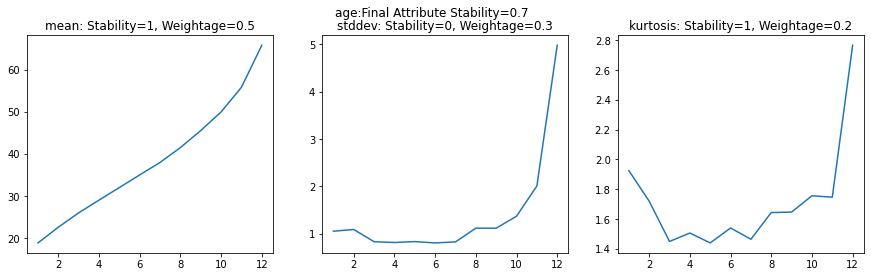

In [26]:
# Example 1 - attribute age
plot_attribute_result('age', df_stability, df_intermediate)

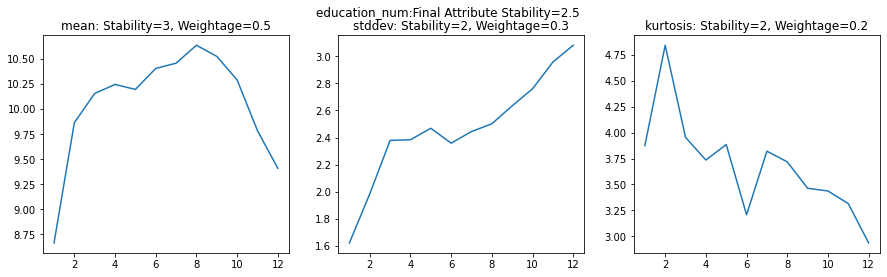

In [27]:
# Example 2 - attribute education_num
plot_attribute_result('education_num', df_stability, df_intermediate)

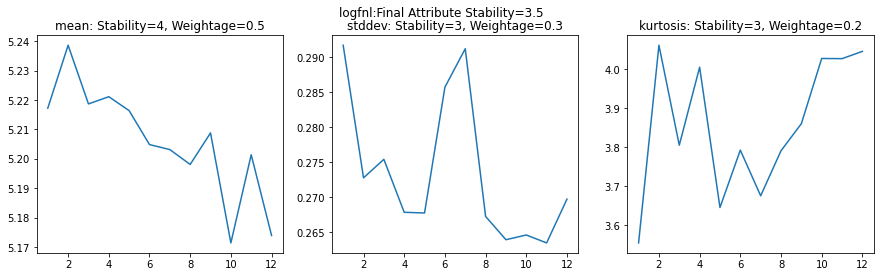

In [28]:
# Example 3 - attribute logfnl
plot_attribute_result('logfnl', df_stability, df_intermediate)